In [821]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

#### Predefined Functions

In [822]:
def draw_circuit(circuit, params=None, **kwargs):
    fig, _ = qml.draw_mpl(circuit, **kwargs)(params)
    fig.show()

def draw_graph(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=16, font_color='black', edge_color='gray')
    plt.show()

def get_bitstrings(n):
    length = len(bin(n-1)) - 2
    binary_numbers = [' ' + bin(i)[2:].zfill(length) + ' ' for i in range(n)]
    return binary_numbers

#### Constants

In [823]:
NUM_QUBITS = 4
LAYERS = 2
ANALYTICAL = True
NUM_SHOTS = 100

## Define the Graph

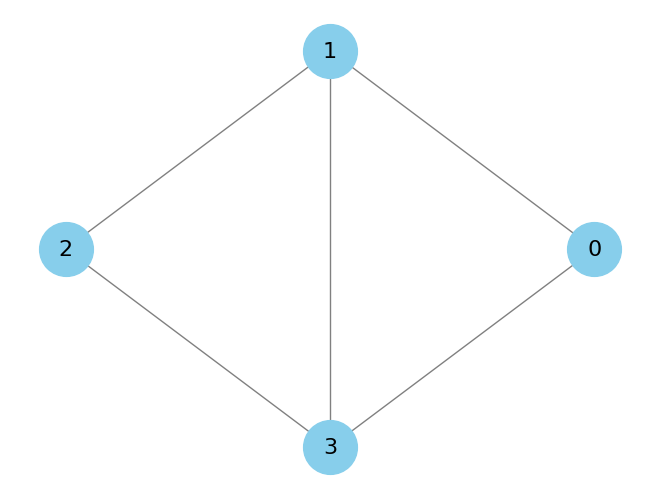

In [824]:
G = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)]

draw_graph(G)

### Define the Hamiltonian and Unitaries

In [825]:
# Cost Hamiltonian
def Hc(graph):
    H = 0
    for u, v in graph:
        H += 0.5 * (1 - qml.PauliZ(u) @ qml.PauliZ(v))
    return H

# Cost Unitary
def Uc(gamma, graph):
    for u, v in graph:
        qml.CNOT(wires=[u, v])
        qml.RZ(gamma, wires=v)
        qml.CNOT(wires=[u, v])

# Mixer Unitary
def Um(beta, n_qubits):
    for i in range(n_qubits):
        qml.RX(beta, wires=i)

### The QAOA Ansatz

In [826]:
def QAOA(gammas, betas, n_layers, n_qubits, graph):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        
    for i in range(n_layers):
        Uc(gammas[i], graph)
        
        Um(betas[i], n_qubits)

### Define the Circuit

In [827]:
dev = qml.device("default.qubit", wires=NUM_QUBITS, shots = None if ANALYTICAL else NUM_SHOTS)

In [828]:
# For optimising the circuit
@qml.qnode(dev)
def circuit(params, n_layers = LAYERS, n_qubits = NUM_QUBITS, graph = G):
    gammas = params[0]
    betas = params[1]
    
    QAOA(gammas, betas, n_layers, n_qubits, graph)
    
    return qml.expval(Hc(graph))

# For sampling from the circuit
@qml.qnode(dev)
def measure(params, n_layers = LAYERS, n_qubits = NUM_QUBITS, graph = G):
    gammas = params[0]
    betas = params[1]
    
    QAOA(gammas, betas, n_layers, n_qubits, graph)
    
    return qml.probs(wires=list(range(n_qubits)))

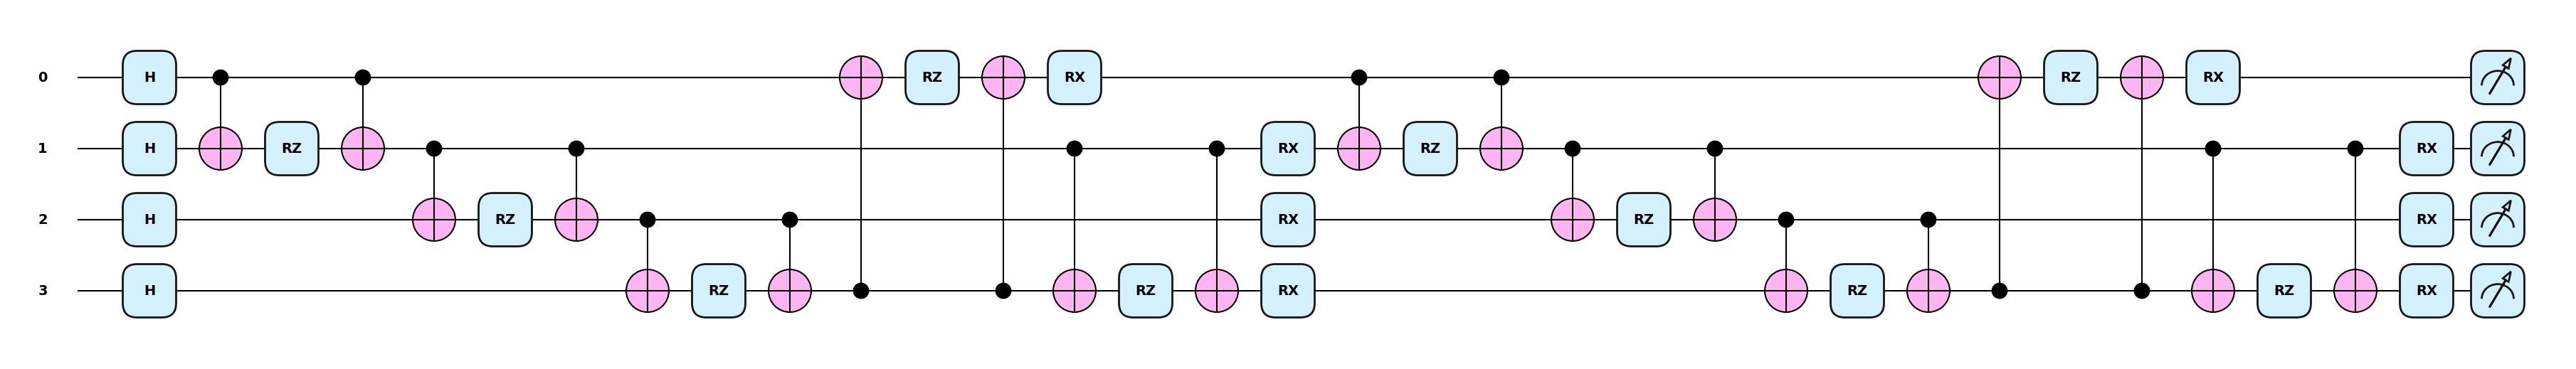

In [829]:
draw_circuit(circuit, np.random.rand(2, LAYERS), style='pennylane')

## Optimising the Parameters

In [830]:
def QAOA_maxcut(cost, n_layers = 1, steps = 100, optimiser = None, log=False):
    if not optimiser:
        optimiser = qml.AdamOptimizer(stepsize=0.1)
    
    loss = []
    
    params = 0.1 * np.random.rand(2, n_layers, requires_grad=True)

    # Iteratively Optimise
    for i in range(steps):
        params = optimiser.step(lambda x: -cost(x), params)
        loss.append(cost(params))
        
        if (i + 1) % 10 == 0 and log:
            print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

    if log: print("Optimized rotation angles: {}".format(params))
    
    return loss, params

In [831]:
loss, params = QAOA_maxcut(circuit, n_layers=LAYERS)

print(f'Gamma = {params[0]}\nBeta = {params[1]}')

Gamma = [-0.51683049 -1.12048477]
Beta = [0.78148383 0.40038178]


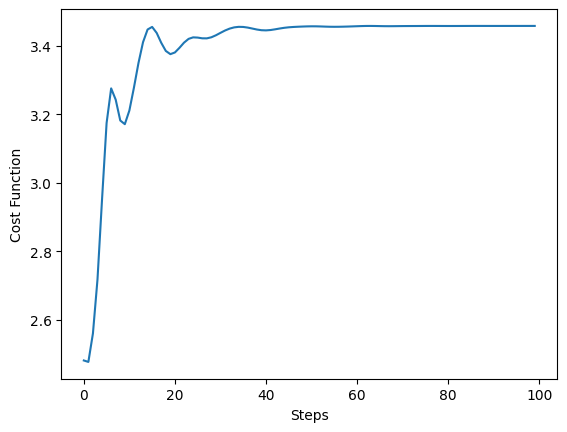

In [832]:
plt.plot(loss)
plt.ylabel('Cost Function')
plt.xlabel('Steps')
plt.show()

In [833]:
observations = measure(params)
bitstrings = get_bitstrings(len(observations))

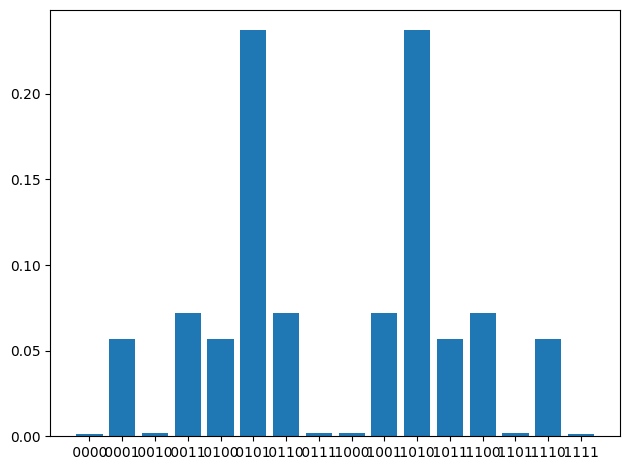

In [834]:
plt.bar(bitstrings, observations)
plt.tight_layout()
plt.show()